# A study on the timeseries forecasting method: ARIMA


## Getting the data

In [1]:
# initial imports
import pandas as pd
import numpy as np 

from TSErrors import FindErrors

import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")


In [2]:
confirmed_global = pd.read_csv(r"./data/country_confirmed.csv")

In [3]:
def get_data(country, confirmed=confirmed_global):
    confirmed = confirmed.groupby("country").sum().T
    confirmed.index = pd.to_datetime(confirmed.index, infer_datetime_format=True)
    data = pd.DataFrame(
            index=confirmed.index, data=confirmed[country].values, columns=["Total"]
        )
    data = data[(data != 0).all(1)]

    data_diff = data.diff()

    # Removing the first value from data_diff 
    # It had no previous value and is a NaN after taking the difference
    data_diff = data_diff[1:]

    return data, data_diff

In [4]:
confirmed_dfs = get_data("India")
confirmed_daily = confirmed_dfs[1]

In [5]:
confirmed_daily.tail()

,Total
2022-03-04,5921.0
2022-03-05,5476.0
2022-03-06,4362.0
2022-03-07,3993.0
2022-03-08,4575.0


In [6]:
# plotting our daily cases
px.line(confirmed_daily, title="Daily Confirmed Cases in India")

## Model Identification

In [7]:
# train test split
confirmed_daily.index.freq="D"
train = confirmed_daily[:int(len(confirmed_daily)*0.9)]
test = confirmed_daily[int(len(confirmed_daily)*0.9):]

There are 2 main things we need to check here while identifying our model:

1. If our time series data is stationary or not
2. Does our time series have a seasonal component or not

### Checking for stationary condition

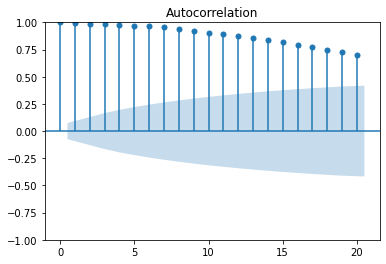

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
acf = plot_acf(train["Total"], lags=20)

In [9]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(ts):
    result = adfuller(ts)
    print(f'p-value: {result[1]}')
    print(f'Lags: {result[2]}')
    print(f'Number of obs: {result[3]}')


In [10]:
adfuller_test(train["Total"])

p-value: 0.07125340763190609
Lags: 20
Number of obs: 670


As seen in the above tests:

1. The ACF plot decreases/declines slowly for different lags
2. The p-value returned by the Augmented Dicky-Fuller (adfuller) test is >0.05

Both of these observations are not consistent with the null hypothesis that the data is stationary. Therefore we **cannot use ARIMA(p,0,q)** or an ARMA model for our time series.

Our next step is to find the order of differencing for our ARIMA model to convert it into stationary data. i.e, to find d-value of the ARIMA(p,d,q) model.


In [11]:
# trying with diff order = 1
train["total_diff"] = train["Total"].diff()

In [12]:
train.head()

,Total,total_diff
2020-01-31,0.0,NaN
2020-02-01,0.0,0.0
2020-02-02,1.0,1.0
2020-02-03,1.0,0.0
2020-02-04,0.0,-1.0


In [13]:
train.dropna(inplace=True)

In [14]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train["total_diff"]))

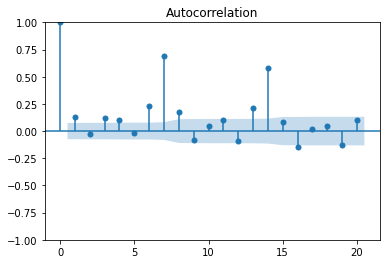

In [15]:
acf = plot_acf(train["total_diff"], lags=20)

In [16]:
adfuller_test(train["total_diff"])

p-value: 4.47491238166199e-06
Lags: 19
Number of obs: 670


In order of differecning 1, we see that:

1. The ACF plot shows no sign of slow decline of autocorrelation over lags. It immediately drops.
2. The p value retuerned by the Dicky-Fuller test is extremely small, and well below the threshold of 0.05.

So with the differencing order of 1, we get a stationary time series data. Therefore we can use **ARIMA(p,1,q)** as our model.

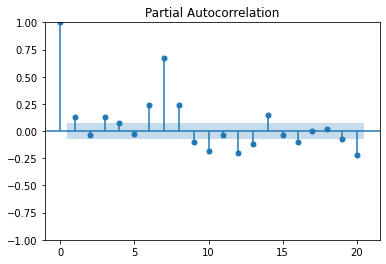

In [17]:
# finding p and q values of new staionary time series
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(train["total_diff"], lags=20, method="ywm")

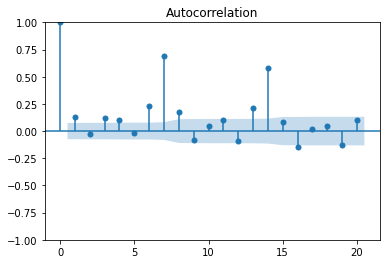

In [18]:
acf = plot_acf(train["total_diff"], lags=20)

### Rules for deciding p and q

#### p value

1. The partial autocorrelation is significant for first p values/lags and then cuts off to zero
2. The ACF decreases exponentially

Point 2 is just a clarifier that the series needs to be stationary for us to select a p-value.
And from our pacf plot we identify that p = 1 (after p/lags=1, it cuts off to zero)

#### q value

1. The Autocorrelation is significant for first q values/lags and then cuts off to zero
2. The PACF decreases exponentially

Again point 2 is just a clarifier that the series needs to be stationary for us to select a q-value. And from our ACF plot we get q = 1

Therefore we have identified our model to be **ARIMA(1,1,1)**

### Checking for seasonality


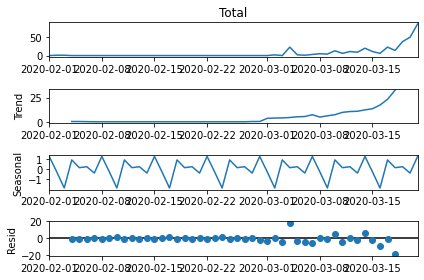

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts_decompose = seasonal_decompose(train["Total"][:50], model="additive")
ts_plot = ts_decompose.plot()

In [20]:
seasonal = ts_decompose.seasonal
fig = px.line(seasonal, title="Seasonality")
fig.show()

In [21]:
adfuller_test(seasonal)

p-value: 0.0
Lags: 7
Number of obs: 42


Therefore D = 0, as seasonal component is already stationary

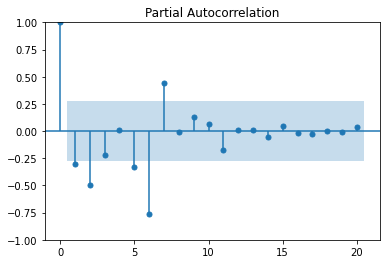

In [22]:
s_pacf = plot_pacf(seasonal, lags=20, method="ywm")

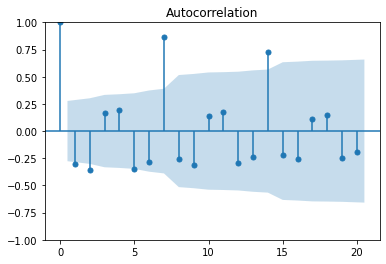

In [23]:
s_acf = plot_acf(seasonal, lags=20)

In [24]:
import statsmodels.api as sm
arima = sm.tsa.statespace.SARIMAX(train['Total'], order=(2,1,2), seasonal_order=(3,0,3,7),)

In [25]:
arima_fit = arima.fit(maxiter=100000,method='nm')

Optimization terminated successfully.
         Current function value: 9.838152
         Iterations: 4623
         Function evaluations: 6368


In [26]:
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                     Total   No. Observations:                  690
Model:             SARIMAX(2, 1, 2)x(3, 0, [1, 2, 3], 7)   Log Likelihood               -6788.325
Date:                                   Thu, 10 Mar 2022   AIC                          13598.650
Time:                                           11:59:19   BIC                          13648.537
Sample:                                       02-01-2020   HQIC                         13617.948
                                            - 12-21-2021                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2394      0.050     24.959      0.000       1.142       1.337
ar.L2         -0.3038      0.047     -6.406      0.000      -0.397      -0.211
ma.L1         -1.4360      0.044    -32.909      0.000      -1.522      -1.350
ma.L2          0.5860      0.043     13.709      0.000       0.502       0.670
ar.S.L7        1.4833      0.457      3.244      0.001       0.587       2.379
ar.S.L14      -0.3248      0.882     -0.368      0.713      -2.054       1.405
ar.S.L21      -0.1633      0.435     -0.376      0.707      -1.015       0.688
ma.S.L7       -1.0278      0.456     -2.252      0.024      -1.922      -0.133
ma.S.L14       0.1021      0.674      0.152      0.880      -1.219       1.423
ma.S.L21      -0.0298      0.210     -0.142      0.887      -0.442       0.382
sigma2      2.093e+07   7.16e-08   2.93e+14      0.000    2.09e+07    2.09e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              6247.34
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               2.78   Skew:                            -0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.67e+30. Standard errors may be unstable.
"""

In [27]:
pred = arima_fit.predict(start=train.index[-1], end=test.index[-1])[1:]

In [28]:
mape = FindErrors(test.Total.values, pred.values).mape()

In [29]:
mape

69.28422470995532

In [30]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train["Total"].values, name="Train"))
fig.add_trace(go.Scatter(x=test.index, y=test["Total"].values, name="Actual"))
fig.add_trace(go.Scatter(x=test.index, y=pred.values, name="Predicted"))

This happens because SARIMAX can be very blunt for hugh frequency data (quoted by one of the authors of statsmodels in this answer [here](https://stats.stackexchange.com/questions/313426/mle-convergence-errors-with-statespace-sarimax)))

Theoretically, this should imnprove significantly if we set the seasonality period to 365 (1/365 a year makes it daily). But this would need very processing power.

To show the same process and to get an optimal result from a monthly dataset I performed the same task given, but with [this](https://www.kaggle.com/odins0n/monthly-gold-prices?select=1979-2021.csv) dataset from kaggle

My working for this starts froim the next section.